# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()


Bad key "text.kerning_factor" on line 4 in
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pymc3 as pm

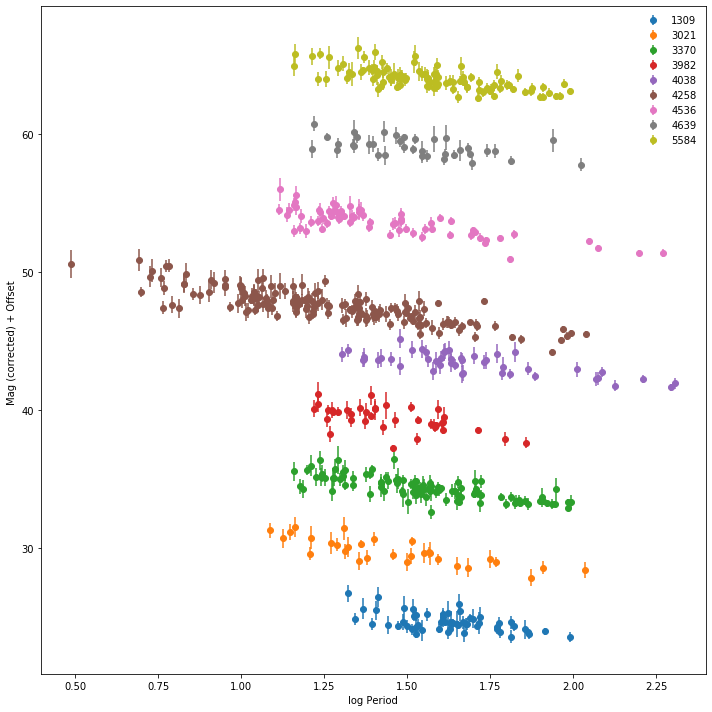

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs+0.1, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

In [4]:
#explore class object.
print(ceph.list_hosts())

print(np.shape(ceph.data))

print(type(ceph.data))

#it isnt expressed but the format of the data is for [j,i] i gives:
    #i=0: id of cepheid
    #i=1: id of galaxy
    #i=2: magnitude observed
    #i=3: error on that magnitude
    #i=4: Period
    #i=5: metallicity
    #i=6: bias.... ???

#can neatly pull the data for the ith host with
    #ceph.select('ID')
    
    #and could use a for loop over:( ceph.list_hosts() ) to grab each correct ID in turn

    #calling the data in this way pulls up the data to select next as methods, as expamply above
    
#try it out
print(' ')
ceph.select(ID=4258) #OIC
print(np.shape(ceph.mobs)) #okay need to change this to weisenheit
print(np.shape(ceph.logP))
print(np.shape(ceph.sigma))
print(ceph.redshifts['4258'])
print(' ')

for i,host in enumerate(ceph.list_hosts()):
    ceph.select(host)
    print(np.shape(ceph.mobs))
    
    #because these are many different sizes, need to create many different sized arrays then place them into a list... or dict?
print(' ')
model_hold = {}
for i,host in enumerate(ceph.list_hosts()):
    ceph.select(host)
    model_hold[host] = np.ones(len(ceph.mobs)) #some dummy values

['1309' '3021' '3370' '3982' '4038' '4258' '4536' '4639' '5584']
(646, 7)
<class 'numpy.ndarray'>
 
(166,)
(166,)
(166,)
0.001494
 
(56,)
(30,)
(101,)
(38,)
(46,)
(166,)
(69,)
(37,)
(103,)
 


# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


In [5]:
#the jth cepheid magnitude in the ith host:
#weisenheitmag_gal_cepheid = (gal_distance_mod - distance_mod_4258) + redshift_4258 + B * np.log(Period_gal_cepheid)

#with weisenheitmag = magnitude_in_H_band - R * (mag_in_V_band - mag_in_I_band)
#but we do not have the mag in each band...

#with R = A_H / (A_V - A_I)

#and where R = 0.410, given by Reiss ... unless we are meant to solve for it???

#algebraically expressed
#mW,i,j = (µ0,i − µ0_4258) + zpW_4258 + bW np.log10(Pi,j) + GAUSSIAN_ERROR

#galaxy 4258 is the 5th index in the host list.

#redshifts are given in the data file

#mag_obs must just be the weisenheit magnitude, since we do not have the other mag in each band

#add priors here....
mu = np.ones(len(ceph.list_hosts())) #* prior_mu # heck I dont know buddy
B=1.0 #* prior_B # I think this is a slope, could be -3?
sigma_int = 1 #* prior_sigma_int #... actually looking at the data this isnt a bad prior...


#for i,host in enumerate(ceph.list_hosts()):
#    ceph.select(host)
#    model_hold[host] = np.ones(len(ceph.mobs)) #some dummy values

def update(mu,B,ceph=ceph):
    #updates model, a dictionary holding different sized arrays queried by hosts
    
    #instantiate a dictionary that will be quertied by host name
    model_hold = {}
    
    #calculate the model and place into the dictionary
    for i,host in enumerate(ceph.list_hosts()):
        ceph.select(host)

        model_hold[host] = (mu[i] - mu[5]) + ceph.redshifts['4258'] + B * (ceph.logP) # \
            #+ np.random.normal(mu=0,sigma=sigma_int,size=len(ceph.logP))
            #we don't want to add a sigma here, that would be dumb: its random thats the point
    
    return model_hold
    
    
def liklihood(B,ceph=ceph,model_hold=model_hold,sigma_int=0.7):
    #computes and returns the liklihood, which I choose as gaussian because the outlier rate seems low...
    if B > 0:
        return(0) #zero probability of this occuring
    
    liklihood_h= 1.0 #instantiate at unity
    for host in ceph.list_host():
        ceph.select(host)
        liklihood_h = liklihood_h * np.prod(np.exp((-1*(model_hold[host] - ceph.mobs)**2 /(2 * ceph.sigma**2 * sigma_int**2))))
        #technically, the error bars above are just the magnitude errors. if the periods also scatter off the surface
        #then there could be some error being unaccounted for in this model, sigma_int from systematics that not all
        #cepheids are alike: i.e. stars are complex churning fusion reactors
        
        #true error would then be ceph: sigma**2 + sigma_int**2, I choose sigma_int to be 0.7 because just looking at how much
        # a true error bar on the data shown above would need to be in order to make the errors perfect normal off the model,
        #I think 0.7 sounds about right. It also appears to be the dominent source of uncertainty in this model: which means
        #that observing these cepheids longer will not provide more precise estimates of the distances to these galaxies
    return liklihood_h
#beutiful, vectorized code

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [6]:
mu = np.ones(len(ceph.list_hosts())) #This is the distance modulus,
#m - M = 5*np.log10(d/10pc)

#mu = 5*np.log10(d/10pc)

#using hubbles law we can find estimate redshifts to each galaxy, then place some uncertainty on it since H_0 
#is uncertain... sigma=4 since favorite values are 73 and 67, and I'll split the difference at 70.
H_0 = np.random.normal(loc=70,scale=4,size=1) #km/s /Mpc
c = 3e5 #km/s
for i,host in enumerate(ceph.list_hosts()):
    v = ceph.redshifts[host]*c #km/s
    D = v/H_0 *1e6 #pc
    mu[i] = 5 * np.log10(D/10) #in magnitudes

#https://en.wikipedia.org/wiki/Propagation_of_uncertainty
####################################
#for function f = a * log10( b * A )
#sigma_f = a*sigmaA / (A*ln(10))

a = 5

#b = 1/10

#A = D

#sigmaA = uncertainty of D
#####################################

#for function A = (z*c/H_0) *1e6 = a/A

#error = (z*c/H_0 * 1e6)*(sigma_H_0/H_0) 

######################################
sigmas_array = np.ones(9)
for i,host in enumerate(ceph.list_hosts()):
    
    A = (ceph.redshifts[host]*3e5/H_0)*1e6
    
    sigmaA = (ceph.redshifts[host]*3e5/H_0)*1e6*(4/H_0)  
    
    sigmas_array[i] = (a * sigmaA) / (A * np.log(10))

sigmas_array

array([0.12556675, 0.12556675, 0.12556675, 0.12556675, 0.12556675,
       0.12556675, 0.12556675, 0.12556675, 0.12556675])

In [7]:
B = np.random.normal(loc=-3,scale=1,size=1) #* prior_B # This is a slope on magnitude from the log(P).

#plotted above, we have many examples of different galaxies. just tracing what a linear model in mag-logP space would be for
#a few lines I get -3. the sigma can be 1 because I'll stay conservative and kind of uninformative. But, I also have
#placed in the liklihood function that liklihood of a positive slope is zero, this is also part of that prior.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [46]:

#okay or do it in a more explicit, dumb way...
all_sigmas = ceph.data[:,3]
all_mags = ceph.data[:,2]
all_logP = ceph.data[:,4]
print(np.shape(all_logP))

#calculate the expected value of mu:
H_0 = np.random.normal(loc=70, scale=4)
expected_mu = np.ones(len(ceph.list_hosts()))
c = 3e5 #km/s
for i,host in enumerate(ceph.list_hosts()):
    v = ceph.redshifts[host]*c #km/s
    D = v/H_0 *1e6 #pc
    expected_mu[i] = 5 * np.log10(D/10)


ceph.select(ceph.list_hosts()[0])
X_0 = ceph.logP
sigmas_0 = ceph.sigma
obs_0 = ceph.mobs

ceph.select(ceph.list_hosts()[1])
X_1 = ceph.logP
sigmas_1 = ceph.sigma
obs_1 = ceph.mobs

ceph.select(ceph.list_hosts()[2])
X_2 = ceph.logP
sigmas_2 = ceph.sigma
obs_2 = ceph.mobs

ceph.select(ceph.list_hosts()[3])
X_3 = ceph.logP
sigmas_3 = ceph.sigma
obs_3 = ceph.mobs

ceph.select(ceph.list_hosts()[4])
X_4 = ceph.logP
sigmas_4 = ceph.sigma
obs_4 = ceph.mobs

ceph.select(ceph.list_hosts()[5])
X_5 = ceph.logP
sigmas_5 = ceph.sigma
obs_5 = ceph.mobs

ceph.select(ceph.list_hosts()[6])
X_6 = ceph.logP
sigmas_6 = ceph.sigma
obs_6 = ceph.mobs

ceph.select(ceph.list_hosts()[7])
X_7 = ceph.logP
sigmas_7 = ceph.sigma
obs_7 = ceph.mobs

ceph.select(ceph.list_hosts()[8])
X_8 = ceph.logP
sigmas_8 = ceph.sigma
obs_8 = ceph.mobs

print(np.shape(expected_mu))
print(np.shape(obs_0))
print(np.shape(sigmas_0))

expected_mu = expected_mu - expected_mu[5]
sigmas_array[5] = 1e-3

with pm.Model() as model:
    
    #variables:
    B = pm.Bound(pm.Normal, upper=0)('B', mu=-3, sigma=1, shape=1)

    mu_0 = pm.Normal('Mu0', mu=expected_mu[0], sigma=sigmas_array[0])
    mu_1 = pm.Normal('Mu1', mu=expected_mu[1], sigma=sigmas_array[1])
    mu_2 = pm.Normal('Mu2', mu=expected_mu[2], sigma=sigmas_array[2])
    mu_3 = pm.Normal('Mu3', mu=expected_mu[3], sigma=sigmas_array[3])
    mu_4 = pm.Normal('Mu4', mu=expected_mu[4], sigma=sigmas_array[4])
    mu_5 = pm.Normal('Mu5', mu=expected_mu[5], sigma=sigmas_array[5])
    mu_6 = pm.Normal('Mu6', mu=expected_mu[6], sigma=sigmas_array[6])
    mu_7 = pm.Normal('Mu7', mu=expected_mu[7], sigma=sigmas_array[7])
    mu_8 = pm.Normal('Mu8', mu=expected_mu[8], sigma=sigmas_array[8])
    
    #I think what is going wrong is that my assumption that this value is the redshift is not correct. it appear to simply be
    #an intercept, in which case I should use make it another parameter in my model 
    z_pw_4258 = ceph.redshifts['4258']
    #but for now lets set it to something reasonable to see if it improves our sampler
    z_pw_4258 = pm.Normal('Z_pw', mu=25, sigma=5)
    """
    model_0 = pm.math.sum((mu_0, -1*mu_5)) + z_pw_4258 + B * (X_0)
    model_1 = pm.math.sum((mu_1, -1*mu_5)) + z_pw_4258 + B * (X_1)
    model_2 = pm.math.sum((mu_2, -1*mu_5)) + z_pw_4258 + B * (X_2)
    model_3 = pm.math.sum((mu_3, -1*mu_5)) + z_pw_4258 + B * (X_3)
    model_4 = pm.math.sum((mu_4, -1*mu_5)) + z_pw_4258 + B * (X_4)
    model_5 = pm.math.sum((mu_5, -1*mu_5)) + z_pw_4258 + B * (X_5)
    model_6 = pm.math.sum((mu_6, -1*mu_5)) + z_pw_4258 + B * (X_6)
    model_7 = pm.math.sum((mu_7, -1*mu_5)) + z_pw_4258 + B * (X_7)
    model_8 = pm.math.sum((mu_8, -1*mu_5)) + z_pw_4258 + B * (X_8)
    """
    
    model_0 = mu_0 + z_pw_4258 + B * (X_0)
    model_1 = mu_1 + z_pw_4258 + B * (X_1)
    model_2 = mu_2 + z_pw_4258 + B * (X_2)
    model_3 = mu_3 + z_pw_4258 + B * (X_3)
    model_4 = mu_4 + z_pw_4258 + B * (X_4)
    model_5 = mu_5 + z_pw_4258 + B * (X_5)
    model_6 = mu_6 + z_pw_4258 + B * (X_6)
    model_7 = mu_7 + z_pw_4258 + B * (X_7)
    model_8 = mu_8 + z_pw_4258 + B * (X_8)
    
    sigma_int=0.1
        
    liklihood = pm.math.concatenate([pm.Normal('liklihood_0', mu=model_0, sigma=np.sqrt(sigmas_0**2 + sigma_int**2), observed=obs_0), \
                 pm.Normal('liklihood_1', mu=model_1, sigma=np.sqrt(sigmas_1**2 + sigma_int**2), observed=obs_1), \
                 pm.Normal('liklihood_2', mu=model_2, sigma=np.sqrt(sigmas_2**2 + sigma_int**2), observed=obs_2), \
                 pm.Normal('liklihood_3', mu=model_3, sigma=np.sqrt(sigmas_3**2 + sigma_int**2), observed=obs_3), \
                 pm.Normal('liklihood_4', mu=model_4, sigma=np.sqrt(sigmas_4**2 + sigma_int**2), observed=obs_4), \
                 pm.Normal('liklihood_5', mu=model_5, sigma=np.sqrt(sigmas_5**2 + sigma_int**2), observed=obs_5), \
                 pm.Normal('liklihood_6', mu=model_6, sigma=np.sqrt(sigmas_6**2 + sigma_int**2), observed=obs_6), \
                 pm.Normal('liklihood_7', mu=model_7, sigma=np.sqrt(sigmas_7**2 + sigma_int**2), observed=obs_7), \
                 pm.Normal('liklihood_8', mu=model_8, sigma=np.sqrt(sigmas_8**2 + sigma_int**2), observed=obs_8)])
    
    samples = pm.sample(5000,cores=1)


(646,)
(9,)
(56,)
(56,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Z_pw, Mu8, Mu7, Mu6, Mu5, Mu4, Mu3, Mu2, Mu1, Mu0, B]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 5500/5500 [01:30<00:00, 60.75it/s]
The acceptance probability does not match the target. It is 0.8812408177376819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9126820592356512, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018E1F27D438>,
      dtype=object)

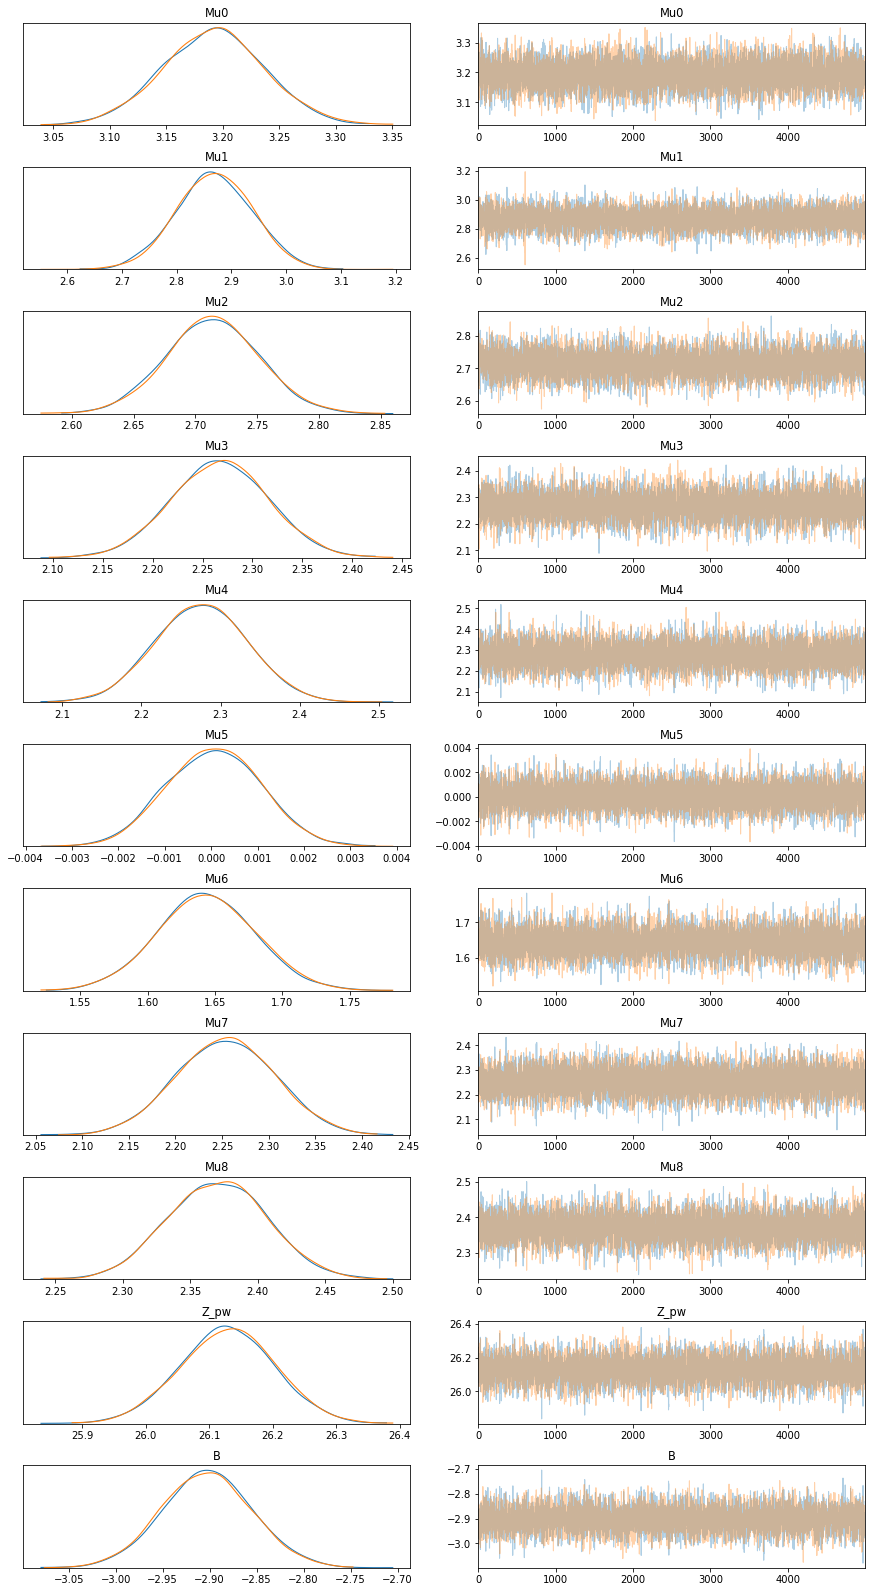

In [47]:
pm.traceplot(samples)

In [60]:
pm.summary(samples)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Mu0,3.192,0.045,3.110,3.280,0.000,0.000,10097.0,10096.0,10095.0,7500.0,1.0
Mu1,2.869,0.068,2.742,2.996,0.001,0.000,11300.0,11300.0,11282.0,7064.0,1.0
Mu2,2.714,0.037,2.645,2.785,0.000,0.000,7717.0,7703.0,7711.0,7280.0,1.0
Mu3,2.268,0.048,2.178,2.359,0.001,0.000,8760.0,8751.0,8752.0,6675.0,1.0
Mu4,2.276,0.058,2.170,2.385,0.001,0.000,9807.0,9788.0,9822.0,6830.0,1.0
Mu5,0.000,0.001,-0.002,0.002,0.000,0.000,14203.0,4135.0,14214.0,7316.0,1.0
Mu6,1.644,0.036,1.575,1.711,0.000,0.000,7989.0,7971.0,8004.0,7229.0,1.0
Mu7,2.254,0.052,2.158,2.353,0.000,0.000,11958.0,11958.0,11985.0,7603.0,1.0
Mu8,2.370,0.036,2.304,2.440,0.000,0.000,8482.0,8482.0,8492.0,7637.0,1.0
Z_pw,26.129,0.073,25.992,26.266,0.001,0.001,6974.0,6974.0,6980.0,7060.0,1.0


In [52]:
ppc = pm.sample_posterior_predictive(samples, samples=500, model=model)

C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 83.85it/s]


In [53]:
samples.varnames

['B_upperbound__',
 'Mu0',
 'Mu1',
 'Mu2',
 'Mu3',
 'Mu4',
 'Mu5',
 'Mu6',
 'Mu7',
 'Mu8',
 'Z_pw',
 'B']

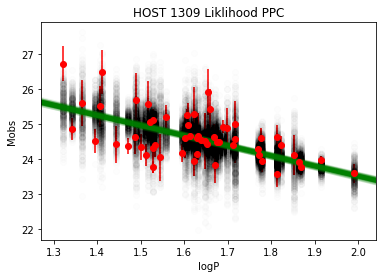

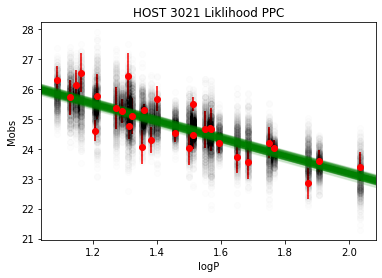

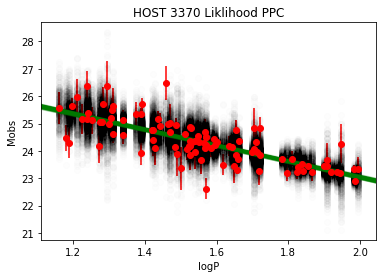

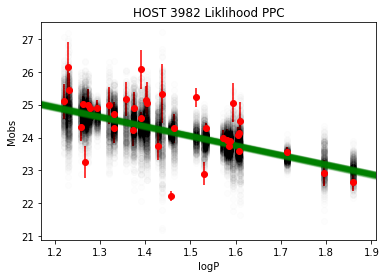

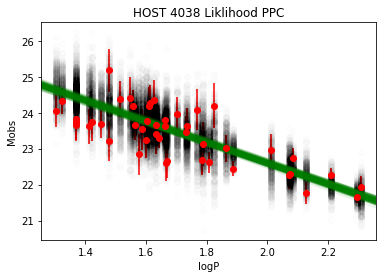

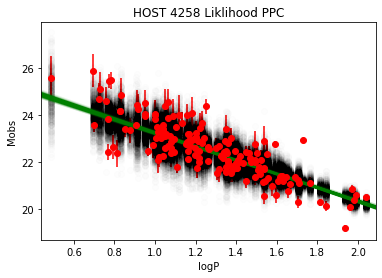

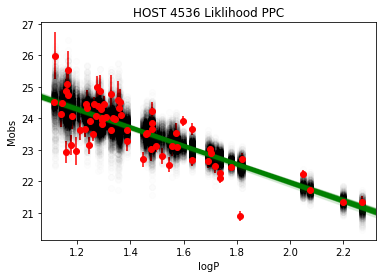

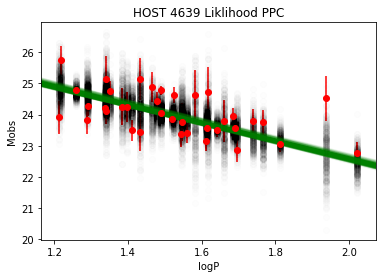

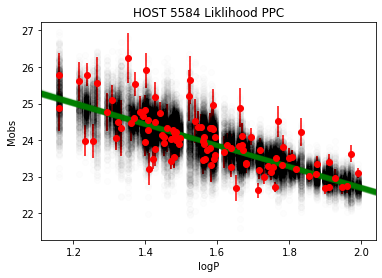

In [54]:
#for each graph, show the ppc
#fig = plt.figure(figsize=(10, 5))

#draw nsamp samples from each variable
nsamp=200
i = np.random.choice(range(samples['B'].shape[0]), size=nsamp)
B = samples['B'][i]

#z_pw_4258 = ceph.redshifts['4258']
#z_pw_4258 = 25
z_pw_4258 = samples['Z_pw'][i]

#B=np.ones(9)*-3 #just to check if I am going crazy

MU = np.ones((nsamp,9))
for j in range(9):
    MU[:,j] = samples[samples.varnames[j+1]][i] #skip B

#plot the posterior predictive samples for our model

#do it for one, then over for
for k,host in enumerate(ceph.list_hosts()):
    for j in range(ppc[list(ppc.keys())[k]].shape[0]):
        ymod = ppc[list(ppc.keys())[k]][j,:]
        ceph.select(ceph.list_hosts()[k])
        plt.plot(ceph.logP,ymod, 'ko', alpha=0.007)

    xmin = min(ceph.logP) - 0.05
    xmax = max(ceph.logP) + 0.05
    x_arr = np.array([xmin,xmax])

    #for MUx, Bx, z_pw_4258x in zip(MU[:,k]-MU[:,5],B,z_pw_4258):
    #    ceph.select(ceph.list_hosts()[k])
    #    plt.plot(x_arr, (MUx) + z_pw_4258x + Bx*x_arr, alpha=0.1, color='green')
    
    ################################################
    #try this to make sense of instructions below
    for MUx, Bx, z_pw_4258x in zip(MU[:,k],B,z_pw_4258):
        ceph.select(ceph.list_hosts()[k])
        plt.plot(x_arr, (MUx) + z_pw_4258x + Bx*x_arr, alpha=0.1, color='green')

    #################################################
    
    
    
    
    plt.errorbar(ceph.logP,ceph.mobs, yerr=ceph.sigma, linestyle='None', color='red', marker='o')

    plt.title('HOST {} Liklihood PPC'.format(str(ceph.list_hosts()[k])))
    plt.xlabel('logP')
    plt.ylabel('Mobs')
    plt.xlim(xmin,xmax)
    plt.show()

In [55]:
#compare to table 3

Riess_table3 = {'4536':1.567,'4639':2.383,'3370':2.835,'3982':2.475,'3021':3.183,'1309':3.276,'5584':2.461,'4038':2.396,'4258':0}

my_means = ((pm.summary(samples)['mean']).values)[1::] 
my_mu = dict(zip(ceph.list_hosts(),my_means))

my_mu['4639'] - ((pm.summary(samples)['mean']).values)[5] #lets see... are my residuals gaussian???

residuals=list()
for i,host in enumerate(list(Riess_table3.keys())):
    residuals.append((my_mu[host] - ((pm.summary(samples)['mean']).values)[5]) - Riess_table3[host])

(array([6., 2., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-2.396 ,  0.2104,  2.8168,  5.4232,  8.0296, 10.636 , 13.2424,
        15.8488, 18.4552, 21.0616, 23.668 ]),
 <a list of 10 Patch objects>)

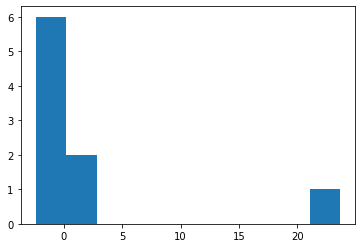

In [56]:
plt.hist(residuals)
#this would suggest a bias is in my model compared to Riess'; this maybe due to the metallicity that he took into account?

#or that my assumption of a gaussian systematic was incorrect-- there is an effect that is nonlinear between logP and mobs that
#my model is unable to capture and that we do not know about...

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

$$ m_{v,i}^0 - (\mu_{0,i} - \mu_{0,4258}) = m_{v,4258}^0$$

Therefore:

$$\log H_0 = \frac{(m_{v,i}^0 - (\mu_{0,i} - \mu_{0,4258})) - \mu_{0,4259} + 5\cdot a_v +25}{5}$$

$$\log H_0 = \frac{m_{v,i}^0 + 5\cdot a_v - \mu_{0,i} + 25}{5}$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

6 5584 0.0014066511568719179
7 4038 199.24453021965726


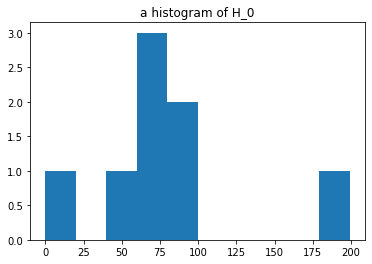

naive : 75.3969128318737
0.00016839965049262205
24.881309554049786


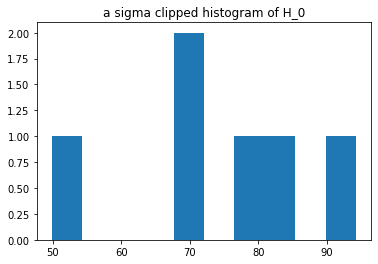

weighted average, my value of H_0:  77.03242426947766
SD:  13.56286967516308
 
...and the typical median value of our error contributing terms are...
 
median of sigma from my fit of mu:  0.045
 
sigma from mu 4258:  0.22671568097509268
 
median of sigma from Riess' SN data:  0.112


In [75]:
#from Humphreys et al, 2013 D_NGC_4258 = 7.60 +/-0.17 +/-0.15 ... 
#distance modulus 4258 = mu_5 = 5*np.log10(7.60e6/10)
humphreys_mu_5 = 5*np.log10(7.60e6/10)

#We need to find m_v^0 for our samples, this is supposed to be the expected, reddening-free, fiducial, peak magnitude of a type
#Ia supernovae observed in some galaxy.
Riess_SN = {'4536':15.147,'4639':16.040,'3370':16.545,'3982':15.953,'3021':16.699,'1309':16.768,'5584':16.274,'4038':15.901}
#we should also use humphreys' mu for mu_0,4258 instead of my_mu[4258]

H_0_back=np.ones(8)
for i,host in enumerate(list(Riess_SN.keys())):
    H_0_back[i] = 10**((-1*(my_mu[host] + humphreys_mu_5)  + Riess_SN[host]  + 25)/5)
    if (30>H_0_back[i]) or H_0_back[i]>100:
        print(i,host,H_0_back[i])

plt.hist(H_0_back)
plt.title('a histogram of H_0')
plt.show()
print('naive :',np.median(H_0_back))

#propogating uncertainty from my_mu, humphreys_mu, and Riess_SN...

# if f = 10^(b * A)

b = 1/5
sigma_humphreys_mu=np.sqrt((0.17**2)+(0.15)**2)
sigma_Riess_SN = {'4536':0.145,'4639':0.111,'3370':0.101,'3982':0.091,'3021':0.113,'1309':0.103,'5584':0.122,'4038':0.137}
sigma_my_mu = dict(zip(ceph.list_hosts(),(pm.summary(samples)['sd'].values)[0:9]))

sigma_H_0=np.ones(8)
for i,host in enumerate(list(sigma_Riess_SN.keys())):
    sigma_a = np.sqrt(sigma_my_mu[host]**2 + (sigma_humphreys_mu)**2 + (sigma_Riess_SN[host])**2)
    sigma_H_0[i] = abs(H_0_back[i])*abs(b * np.log(10) * sigma_a)

print(sigma_H_0[6])
print(sigma_H_0[7])

#If I choose 3 sigma clipping,...

#I eliminate the 4038 galaxy because 199-75 > 75.39
#I eliminate the 5584 galaxy because 1e-3 + 3*1e-3 < 75.39

#now lets look at the result.

plt.hist(H_0_back[0:6])
plt.title('a sigma clipped histogram of H_0')
plt.show()
print('weighted average, my value of H_0: ',np.average(H_0_back[0:6],weights=sigma_H_0[0:6]))
print('SD: ',np.std(H_0_back[0:6]))

print(' ')
print('...and the typical median value of our error contributing terms are...')
print(' ')
print('median of sigma from my fit of mu: ',np.median(list(sigma_my_mu.values())))
print(' ')
print('sigma from mu 4258: ',sigma_humphreys_mu)
print(' ')
print("median of sigma from Riess' SN data: ",np.median(list(sigma_Riess_SN.values())))

Therefore my error on H_0 is dominated by the error from Humphrey's value of the distance modulus to galaxy NGC 4258